In [43]:
import numpy as np
import pandas as pd

from six.moves import cPickle as pickle

import theano
import theano.tensor as T

from lib.rbm import RSM

import matplotlib.pyplot as plt
%matplotlib inline

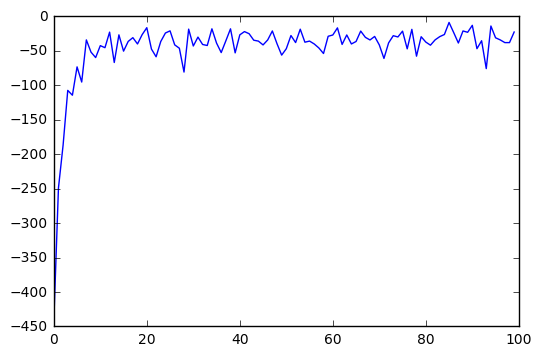

In [53]:
plt_dat = np.genfromtxt('dbn_params/lproxy_layer_2.csv', delimiter=',', names = True) #'model_params/likelihood_proxy.csv'
plt.plot(plt_dat)
plt.show()

In [3]:
dat_x = np.genfromtxt('data/dtm_20news.csv', dtype='float32', delimiter=',', skip_header = 1)
dat_y = dat_x[:,0]
dat_x = dat_x[:,1:]
vocab =  np.genfromtxt('data/dtm_20news.csv', dtype=str, delimiter=',', max_rows = 1)[1:]
test_input = theano.shared(dat_x)

In [4]:
dat_x.shape

(18828, 2756)

In [36]:
def score_rsm(input, learning_rate=0.002, 
             training_epochs=50, batch_size=400, 
             n_hidden=2000, model_src = 'model_params/rsm_epoch_80.pkl'):

    train_set_x = input
    N_input_x = train_set_x.shape[0]
    
    # compute number of minibatches for scoring
    N_splits = int( np.floor(train_set_x.get_value(borrow=True).shape[0] / batch_size) + 1 )

    # allocate symbolic variables for the data
    index = T.lscalar()    # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    
    # construct the RBM class
    rsm = RSM(input=x, n_visible=train_set_x.get_value(borrow=True).shape[1],
              n_hidden=n_hidden)#, numpy_rng=rng, theano_rng=theano_rng)
    
    # ensure model source directory is valid
    assert type(model_src) == str or model_src is not None
    
    # load saved model
    rsm.__setstate__(pickle.load(open(model_src, 'rb')))
    
    # extract the features w.r.t inputs
    _, hid_extract = rsm.propup(x, x.sum(axis=1))
        
    # start-snippet-5
    # it is ok for a theano function to have no output
    # the purpose of train_rbm is solely to update the RBM parameters
    score = theano.function(
        inputs = [index],
        outputs = hid_extract,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    return np.concatenate( [score(ii) for ii in range(N_splits)], axis=0 )


In [37]:
rsm = score_rsm(input=test_input, n_hidden = 0)

In [54]:
rsm.shape

(18828, 2000)

In [26]:
rsm[18828-1].sum()

878.73932

In [55]:
rsm[:2,]

array([[  1.92498332e-38,   4.09554756e-38,   0.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00]], dtype=float32)